<a href="https://colab.research.google.com/github/explcre/pipeDejavu/blob/main/auto_pipeline_slicing_dp_ipynb-copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

# Define a simple input tensor with 7 elements
x = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], requires_grad=True)

# Apply the max operation on the input tensor
max_value, max_idx = torch.max(x,dim=0)

# Define the loss function as the max value
loss = max_value

# Compute the gradients
loss.backward()

# Print the gradients with respect to the input tensor
print("Gradients: ", x.grad)


Gradients:  tensor([0., 0., 0., 0., 0., 0., 1.])


In [9]:
import time
def knapsack(items, capacity):
    n = len(items)
    dp = [[0 for _ in range(capacity + 1)] for _ in range(n + 1)]

    for i in range(1, n + 1):
        weight, value = items[i - 1]
        for w in range(capacity + 1):
            if weight <= w:
                dp[i][w] = max(dp[i - 1][w], dp[i - 1][w - weight] + value)
            else:
                dp[i][w] = dp[i - 1][w]

    selected_items = []
    i, w = n, capacity
    while i > 0 and w > 0:
        weight, value = items[i - 1]
        if dp[i][w] != dp[i - 1][w]:
            selected_items.append(i - 1)
            w -= weight
        i -= 1

    return dp[n][capacity], selected_items

# Example usage:
items = [(2, 3), (3, 4), (4, 5), (5, 6)]  # (weight, value)
capacity = 5
start=time.time()
max_value, selected_items = knapsack(items, capacity)
end=time.time()
print(max_value, selected_items)
print("time=",end-start)

7 [1, 0]
time= 0.00019359588623046875


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

def soft_knapsack(items, capacity, iterations=5000, learning_rate=0.01):
    n = len(items)
    weights, values = zip(*items)
    weights = torch.tensor(weights, dtype=torch.float)
    values = torch.tensor(values, dtype=torch.float)

    item_selection = torch.rand(n, requires_grad=True)
    optimizer = optim.Adam([item_selection], lr=learning_rate)

    for _ in range(iterations):
        optimizer.zero_grad()
        soft_selection = torch.sigmoid(item_selection)
        total_weight = torch.sum(soft_selection * weights)
        total_value = torch.sum(soft_selection * values)
        capacity_penalty = torch.clamp(total_weight - capacity, min=0) ** 2

        loss = -(total_value - capacity_penalty)
        loss.backward()
        optimizer.step()

    final_selection = torch.sigmoid(item_selection) > 0.5
    selected_items = [i for i, selected in enumerate(final_selection) if selected]
    max_value = torch.sum(final_selection * values).item()

    return max_value, selected_items

# Example usage:
items = [(2, 3), (3, 4), (4, 5), (5, 6)]  # (weight, value)
capacity = 5
start=time.time()
max_value, selected_items = soft_knapsack(items, capacity)
end=time.time()
print(max_value, selected_items)
print("time=",end-start)

7.0 [0, 1]
time= 3.351736068725586


In [38]:
def soft_knapsack(items, capacity, iterations=5000, learning_rate=0.01, temperature=0.5):
    n = len(items)
    weights, values = zip(*items)
    weights = torch.tensor(weights, dtype=torch.float)
    values = torch.tensor(values, dtype=torch.float)

    item_selection = torch.rand(n, requires_grad=True)
    optimizer = optim.RMSprop([item_selection], lr=learning_rate)

    for _ in range(iterations):
        optimizer.zero_grad()
        soft_selection = torch.sigmoid(item_selection / temperature)
        total_weight = torch.sum(soft_selection * weights)
        total_value = torch.sum(soft_selection * values)
        capacity_penalty = torch.clamp(total_weight - capacity, min=0) ** 2

        loss = -(total_value - capacity_penalty)
        loss.backward()
        optimizer.step()

    final_selection = torch.sigmoid(item_selection / temperature) > 0.5
    selected_items = [i for i, selected in enumerate(final_selection) if selected]
    max_value = torch.sum(final_selection * values).item()

    return max_value, selected_items

In [40]:
def soft_knapsack(items, capacity, iterations=5000, learning_rate=0.01, temperature=0.5):
    n = len(items)
    weights, values = zip(*items)
    weights = torch.tensor(weights, dtype=torch.float)
    values = torch.tensor(values, dtype=torch.float)

    item_selection = torch.rand(n, requires_grad=True)
    optimizer = optim.RMSprop([item_selection], lr=learning_rate)

    for i in range(iterations):
        optimizer.zero_grad()
        soft_selection = torch.sigmoid(item_selection / temperature)
        total_weight = torch.sum(soft_selection * weights)
        total_value = torch.sum(soft_selection * values)
        capacity_penalty = torch.clamp(total_weight - capacity, min=0) ** 2

        loss = -(total_value - capacity_penalty)
        loss.backward()
        optimizer.step()

        # Clamp item_selection values between -5 and 5
        item_selection.data.clamp_(-5, 5)

        # Print intermediate results
        if (i + 1) % 500 == 0:
            print(f"Iteration {i+1}: loss={loss.item():.2f}, total_value={total_value.item():.2f}, total_weight={total_weight.item():.2f}")

    final_selection = torch.sigmoid(item_selection / temperature) > 0.5
    selected_items = [i for i, selected in enumerate(final_selection) if selected]
    max_value = torch.sum(final_selection * values).item()

    return max_value, selected_items

In [46]:
from collections import namedtuple

Solution = namedtuple("Solution", ["value", "items", "selection"])

def soft_knapsack(items, capacity, n_best=5, iterations=5000, learning_rate=0.01, temperature=0.5):
    n = len(items)
    weights, values = zip(*items)
    weights = torch.tensor(weights, dtype=torch.float)
    values = torch.tensor(values, dtype=torch.float)

    item_selection = torch.rand(n, requires_grad=True)
    optimizer = optim.RMSprop([item_selection], lr=learning_rate)

    best_solutions = []

    for i in range(iterations):
        optimizer.zero_grad()
        soft_selection = torch.sigmoid(item_selection / temperature)
        total_weight = torch.sum(soft_selection * weights)
        total_value = torch.sum(soft_selection * values)
        capacity_penalty = torch.clamp(total_weight - capacity, min=0) ** 2

        loss = -(total_value - capacity_penalty)
        loss.backward()
        optimizer.step()

        # Clamp item_selection values between -5 and 5
        item_selection.data.clamp_(-5, 5)

        # Update best solutions
        final_selection = torch.sigmoid(item_selection / temperature) > 0.5
        selected_items = [i for i, selected in enumerate(final_selection) if selected]
        max_value = torch.sum(final_selection * values).item()
        current_solution = Solution(max_value, selected_items, final_selection)

        if len(best_solutions) < n_best:
            best_solutions.append(current_solution)
            best_solutions.sort(key=lambda x: x.value, reverse=True)
        elif max_value > best_solutions[-1].value:
            best_solutions.pop()
            best_solutions.append(current_solution)
            best_solutions.sort(key=lambda x: x.value, reverse=True)

    return best_solutions

In [51]:
from collections import namedtuple

Solution = namedtuple("Solution", ["value", "items", "selection"])

def soft_knapsack(items, capacity, n_best=5, iterations=5000, learning_rate=0.01, temperature=0.5, print_every=500):
    n = len(items)
    weights, values = zip(*items)
    weights = torch.tensor(weights, dtype=torch.float)
    values = torch.tensor(values, dtype=torch.float)

    item_selection = torch.rand(n, requires_grad=True)
    optimizer = optim.RMSprop([item_selection], lr=learning_rate)

    best_solutions = []

    for i in range(iterations):
        optimizer.zero_grad()
        soft_selection = torch.sigmoid(item_selection / temperature)
        total_weight = torch.sum(soft_selection * weights)
        total_value = torch.sum(soft_selection * values)
        capacity_penalty = torch.clamp(total_weight - capacity, min=0) ** 2

        loss = -(total_value - capacity_penalty)
        loss.backward()
        optimizer.step()

        # Clamp item_selection values between -5 and 5
        item_selection.data.clamp_(-5, 5)

        # Update best solutions
        final_selection = torch.sigmoid(item_selection / temperature) > 0.5
        selected_items = [i for i, selected in enumerate(final_selection) if selected]
        max_value = torch.sum(final_selection * values).item()
        current_solution = Solution(max_value, selected_items, final_selection)

        if len(best_solutions) < n_best:
            best_solutions.append(current_solution)
            best_solutions.sort(key=lambda x: x.value, reverse=True)
        elif max_value > best_solutions[-1].value:
            best_solutions.pop()
            best_solutions.append(current_solution)
            best_solutions.sort(key=lambda x: x.value, reverse=True)

        # Print intermediate results
        if (i + 1) % print_every == 0:
            best_solution = best_solutions[0]
            print(f"Iteration {i+1}: loss={loss.item():.2f}, total_value={total_value.item():.2f}, total_weight={total_weight.item():.2f}")
            print(f"Best solution so far: value={best_solution.value}, items={best_solution.items}")

    max_value = best_solutions[0].value
    selected_items = best_solutions[0].items
    return max_value, selected_items, best_solutions

# Time and run the differentiable knapsack solution
start_time = time.time()
max_value_diff, selected_items_diff, best_solutions = soft_knapsack(items, capacity, n_best=5, iterations=5000, learning_rate=0.01, temperature=0.5, print_every=500)
end_time = time.time()

print(f"Differentiable Knapsack: max_value={max_value_diff}, selected_items={selected_items_diff}, time={end_time - start_time:.2f}s")


Iteration 500: loss=56169.26, total_value=1222.51, total_weight=1239.57
Best solution so far: value=22315.0, items=[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211

In [56]:
from collections import namedtuple

Solution = namedtuple("Solution", ["value", "items", "selection"])
def soft_knapsack(items, capacity, n_best=5, iterations=5000, learning_rate=0.01, temperature=0.5, print_every=500):
    n = len(items)
    weights, values = zip(*items)
    weights = torch.tensor(weights, dtype=torch.float)
    values = torch.tensor(values, dtype=torch.float)

    item_selection = torch.rand(n, requires_grad=True)
    optimizer = optim.RMSprop([item_selection], lr=learning_rate)

    best_solutions = []

    for i in range(iterations):
        optimizer.zero_grad()
        soft_selection = torch.sigmoid(item_selection / temperature)
        total_weight = torch.sum(soft_selection * weights)
        total_value = torch.sum(soft_selection * values)
        capacity_penalty = torch.clamp(total_weight - capacity, min=0) ** 2

        loss = -(total_value - capacity_penalty)
        loss.backward()
        optimizer.step()

        # Clamp item_selection values between -5 and 5
        item_selection.data.clamp_(-5, 5)

        # Update best solutions only if the solution is valid (total_weight <= capacity)
        if total_weight <= capacity:
            final_selection = torch.sigmoid(item_selection / temperature) > 0.5
            selected_items = [i for i, selected in enumerate(final_selection) if selected]
            max_value = torch.sum(final_selection * values).item()
            current_solution = Solution(max_value, selected_items, final_selection)

            if len(best_solutions) < n_best:
                best_solutions.append(current_solution)
                best_solutions.sort(key=lambda x: x.value, reverse=True)
            elif max_value > best_solutions[-1].value:
                best_solutions.pop()
                best_solutions.append(current_solution)
                best_solutions.sort(key=lambda x: x.value, reverse=True)

        # Print intermediate results
        if (i + 1) % print_every == 0:
            best_solution = best_solutions[0]
            print(f"Iteration {i+1}: loss={loss.item():.2f}, total_value={total_value.item():.2f}, total_weight={total_weight.item():.2f}")
            print(f"Best solution so far: value={best_solution.value}, items={best_solution.items}")

    max_value = best_solutions[0].value
    selected_items = best_solutions[0].items
    return max_value, selected_items, best_solutions


In [73]:
from collections import namedtuple

Solution = namedtuple("Solution", ["value", "items", "selection"])

def soft_knapsack(items, capacity, n_best=5, iterations=5000, learning_rate=0.01, temperature=0.5, print_every=500, penalty_factor=1e7):
    n = len(items)
    weights, values = zip(*items)
    weights = torch.tensor(weights, dtype=torch.float)
    values = torch.tensor(values, dtype=torch.float)

    item_selection = torch.rand(n, requires_grad=True)
    optimizer = optim.RMSprop([item_selection], lr=learning_rate)

    best_solutions = []

    for i in range(iterations):
        optimizer.zero_grad()
        soft_selection = torch.sigmoid(item_selection / temperature)
        total_weight = torch.sum(soft_selection * weights)
        total_value = torch.sum(soft_selection * values)
        capacity_penalty = torch.clamp(total_weight - capacity, min=0) ** 2

        # Multiply capacity_penalty by a large constant
        loss = -(total_value - penalty_factor * capacity_penalty)
        loss.backward()
        optimizer.step()

        # Clamp item_selection values between -5 and 5
        item_selection.data.clamp_(-5, 5)

        # Update best solutions
        final_selection = torch.sigmoid(item_selection / temperature) > 0.5
        selected_items = [i for i, selected in enumerate(final_selection) if selected]
        max_value = torch.sum(final_selection * values).item()
        current_solution = Solution(max_value, selected_items, final_selection)

        if len(best_solutions) < n_best:
            best_solutions.append(current_solution)
            best_solutions.sort(key=lambda x: x.value, reverse=True)
        elif max_value > best_solutions[-1].value:
            best_solutions.pop()
            best_solutions.append(current_solution)
            best_solutions.sort(key=lambda x: x.value, reverse=True)

        # Print intermediate results
        if (i + 1) % print_every == 0:
            best_solution = best_solutions[0]
            print(f"Iteration {i+1}: loss={loss.item():.2f}, total_value={total_value.item():.2f}, total_weight={total_weight.item():.2f}")
            print(f"Best solution so far: value={best_solution.value}, items={best_solution.items}")

    max_value = best_solutions[0].value
    selected_items = best_solutions[0].items
    return max_value, selected_items, best_solutions


In [80]:
def knapsack(items, capacity, print_every=500):
    n = len(items)
    dp = [[0 for _ in range(capacity + 1)] for _ in range(n + 1)]

    best_solutions_dp = []

    for i in range(1, n + 1):
        weight, value = items[i - 1]
        for w in range(capacity + 1):
            if weight <= w:
                dp[i][w] = max(dp[i - 1][w], dp[i - 1][w - weight] + value)
            else:
                dp[i][w] = dp[i - 1][w]

        if i % print_every == 0:
            best_solutions_dp.append(dp[i][-1])
            print(f"Iteration {i}: Best solution so far for DP: value={dp[i][-1]}")

    selected_items = []
    i, w = n, capacity
    while i > 0 and w > 0:
        weight, value = items[i - 1]
        if dp[i][w] != dp[i - 1][w]:
            selected_items.append(i - 1)
            w -= weight
        i -= 1

    return dp[n][capacity], selected_items, best_solutions_dp


In [19]:

def knapsack(items, capacity, print_every=500,timer_every=10):
    n = len(items)
    dp = [[0 for _ in range(capacity + 1)] for _ in range(n + 1)]

    best_solutions_dp = []

    start_time = time.time()
    for i in range(1, n + 1):
        weight, value = items[i - 1]
        for w in range(capacity + 1):
            if weight <= w:
                dp[i][w] = max(dp[i - 1][w], dp[i - 1][w - weight] + value)
            else:
                dp[i][w] = dp[i - 1][w]
            
        if i % timer_every == 0:
            elapsed_time = time.time() - start_time
            best_solutions_dp.append((elapsed_time, dp[i][-1]))
        if i % print_every == 0:
            
            print(f"Iteration {i}: Best solution so far for DP: value={dp[i][-1]}, elapsed_time={elapsed_time:.2f}s")

    selected_items = []
    i, w = n, capacity
    while i > 0 and w > 0:
        weight, value = items[i - 1]
        if dp[i][w] != dp[i - 1][w]:
            selected_items.append(i - 1)
            w -= weight
        i -= 1

    return dp[n][capacity], selected_items, best_solutions_dp


In [38]:
from collections import namedtuple

#Solution = namedtuple("Solution", ["value", "items", "selection"])

Solution = namedtuple("Solution", ["value", "items", "selection", "elapsed_time"])

def soft_knapsack(items, capacity, n_best=10000, iterations=10000, learning_rate=100, temperature=0.5, print_every=500, penalty_factor=1e7):
    n_best=iterations
    n = len(items)
    weights, values = zip(*items)
    weights = torch.tensor(weights, dtype=torch.float)
    values = torch.tensor(values, dtype=torch.float)

    item_selection = torch.rand(n, requires_grad=True)
    optimizer = optim.RMSprop([item_selection], lr=learning_rate)

    best_solutions = []

    start_time = time.time()
    for i in range(iterations):
        optimizer.zero_grad()
        soft_selection = torch.sigmoid(item_selection / temperature)
        total_weight = torch.sum(soft_selection * weights)
        total_value = torch.sum(soft_selection * values)
        capacity_penalty = torch.clamp(total_weight - capacity, min=0) ** 2

        # Multiply capacity_penalty by a large constant
        loss = -(total_value - penalty_factor * capacity_penalty)
        loss.backward()
        optimizer.step()

        # Clamp item_selection values between -5 and 5
        item_selection.data.clamp_(-5, 5)
        if total_weight <= capacity:
          # Update best solutions
          final_selection = torch.sigmoid(item_selection / temperature) > 0.5
          selected_items = [i for i, selected in enumerate(final_selection) if selected]
          max_value = torch.sum(final_selection * values).item()
          current_solution = Solution(max_value, selected_items, final_selection,time.time() - start_time)
          #best_solution = best_solutions[0]
          if len(best_solutions) < n_best:
              best_solutions.append(current_solution)
              best_solutions.sort(key=lambda x: x.value, reverse=True)
          elif max_value > best_solutions[-1].value:
              best_solutions.pop()
              best_solutions.append(current_solution)
              best_solutions.sort(key=lambda x: x.value, reverse=True)
              # Print intermediate results
        if (i + 1) % print_every == 0:
            elapsed_time = time.time() - start_time
            best_solution = best_solutions[0]
            print(f"Iteration {i+1}: loss={loss.item():.2f}, total_value={total_value.item():.2f}, total_weight={total_weight.item():.2f}, elapsed_time={elapsed_time:.2f}s")
            print(f"Best solution so far: value={best_solution.value}, items={best_solution.items}")

    max_value = best_solutions[0].value
    selected_items = best_solutions[0].items

    best_solutions_diff = sorted([(s.elapsed_time, s.value) for s in best_solutions], key=lambda x: x[0])
    #best_solutions_diff = [(s.elapsed_time, s.value) for s in best_solutions]

    return max_value, selected_items, best_solutions_diff


'''
def soft_knapsack(items, capacity, n_best=5, iterations=5000, learning_rate=0.01, temperature=0.5, print_every=500, penalty_factor=1e7):
    start_time = time.time()
    n = len(items)
    weights, values = zip(*items)
    weights = torch.tensor(weights, dtype=torch.float)
    values = torch.tensor(values, dtype=torch.float)

    item_selection = torch.rand(n, requires_grad=True)
    optimizer = optim.RMSprop([item_selection], lr=learning_rate)

    best_solutions = []

    for i in range(iterations):
        optimizer.zero_grad()
        soft_selection = torch.sigmoid(item_selection / temperature)
        total_weight = torch.sum(soft_selection * weights)
        total_value = torch.sum(soft_selection * values)
        capacity_penalty = torch.clamp(total_weight - capacity, min=0) ** 2

        # Multiply capacity_penalty by a large constant
        loss = -(total_value - penalty_factor * capacity_penalty)
        loss.backward()
        optimizer.step()

        # Clamp item_selection values between -5 and 5
        item_selection.data.clamp_(-5, 5)

        # Update best solutions
        final_selection = torch.sigmoid(item_selection / temperature) > 0.5
        selected_items = [i for i, selected in enumerate(final_selection) if selected]
        max_value = torch.sum(final_selection * values).item()
        current_solution = Solution(max_value, selected_items, final_selection, time.time() - start_time)

        if len(best_solutions) < n_best:
            best_solutions.append(current_solution)
            best_solutions.sort(key=lambda x: x.value, reverse=True)
        elif max_value > best_solutions[-1].value:
            best_solutions.pop()
            best_solutions.append(current_solution)
            best_solutions.sort(key=lambda x: x.value, reverse=True)

        # Print intermediate results
        if (i + 1) % print_every == 0:
            best_solution = best_solutions[0]
            print(f"Iteration {i+1}: loss={loss.item():.2f}, total_value={total_value.item():.2f}, total_weight={total_weight.item():.2f}")
            print(f"Best solution so far: value={best_solution.value}, items={best_solution.items}")

    max_value = best_solutions[0].value
    selected_items = best_solutions[0].items
    best_solutions_diff = [(s.elapsed_time, s.value) for s in best_solutions]

    return max_value, selected_items, best_solutions_diff
'''

'\ndef soft_knapsack(items, capacity, n_best=5, iterations=5000, learning_rate=0.01, temperature=0.5, print_every=500, penalty_factor=1e7):\n    start_time = time.time()\n    n = len(items)\n    weights, values = zip(*items)\n    weights = torch.tensor(weights, dtype=torch.float)\n    values = torch.tensor(values, dtype=torch.float)\n\n    item_selection = torch.rand(n, requires_grad=True)\n    optimizer = optim.RMSprop([item_selection], lr=learning_rate)\n\n    best_solutions = []\n\n    for i in range(iterations):\n        optimizer.zero_grad()\n        soft_selection = torch.sigmoid(item_selection / temperature)\n        total_weight = torch.sum(soft_selection * weights)\n        total_value = torch.sum(soft_selection * values)\n        capacity_penalty = torch.clamp(total_weight - capacity, min=0) ** 2\n\n        # Multiply capacity_penalty by a large constant\n        loss = -(total_value - penalty_factor * capacity_penalty)\n        loss.backward()\n        optimizer.step()\n\n  

In [39]:
import time
import random

def generate_test_case(n, weight_range, value_range, capacity):
    items = [(random.randint(*weight_range), random.randint(*value_range)) for _ in range(n)]
    return items, capacity

Iteration 500: Best solution so far for DP: value=18072, elapsed_time=22.76s
Iteration 1000: Best solution so far for DP: value=26416, elapsed_time=46.04s
Iteration 500: loss=-2.31, total_value=2.31, total_weight=22.54, elapsed_time=1.48s
Best solution so far: value=0.0, items=[]
Iteration 1000: loss=-2.31, total_value=2.31, total_weight=22.54, elapsed_time=2.89s
Best solution so far: value=0.0, items=[]
Iteration 1500: loss=-2.31, total_value=2.31, total_weight=22.54, elapsed_time=4.43s
Best solution so far: value=0.0, items=[]
Iteration 2000: loss=-2.31, total_value=2.31, total_weight=22.54, elapsed_time=5.94s
Best solution so far: value=0.0, items=[]
Iteration 2500: loss=-2.31, total_value=2.31, total_weight=22.54, elapsed_time=7.62s
Best solution so far: value=0.0, items=[]
Iteration 3000: loss=-2.31, total_value=2.31, total_weight=22.54, elapsed_time=9.44s
Best solution so far: value=0.0, items=[]
Iteration 3500: loss=-2.31, total_value=2.31, total_weight=22.54, elapsed_time=12.12

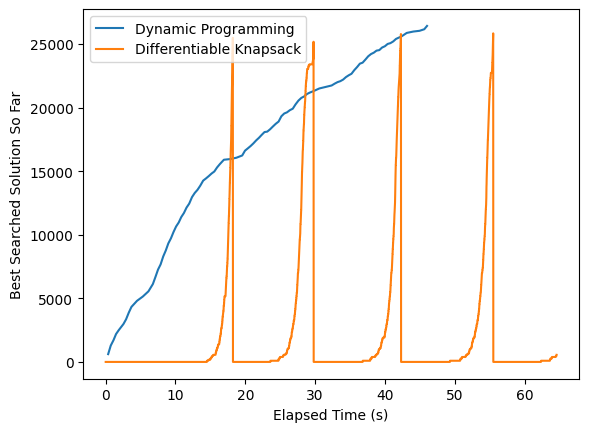

In [40]:
import time
import torch
import torch.optim as optim
from collections import namedtuple
import matplotlib.pyplot as plt
# Generate a large test case with a large capacity
n = 1000
weight_range = (1, 1000)
value_range = (1, 100)
capacity = 100000

# Test and visualization
items, capacity = generate_test_case(n, weight_range, value_range, capacity)

start_time = time.time()
max_value_dp, selected_items_dp, best_solutions_dp = knapsack(items, capacity)
end_time = time.time()
elapsed_time_dp = end_time - start_time

start_time = time.time()
max_value_diff, selected_items_diff, best_solutions_diff = soft_knapsack(items, capacity,iterations=15000,learning_rate=100)
end_time = time.time()
elapsed_time_diff = end_time - start_time


# Plot the best searched solution so far vs elapsed time for both methods
dp_time, dp_values = zip(*best_solutions_dp)
diff_time, diff_values = zip(*best_solutions_diff)


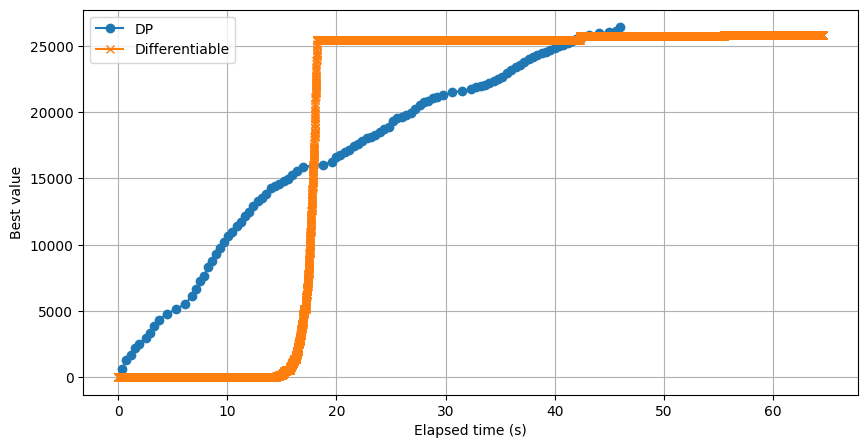

'\nplt.plot(dp_time, dp_values, label="Dynamic Programming")\nplt.plot(diff_time, diff_values, label="Differentiable Knapsack")\nplt.xlabel("Elapsed Time (s)")\nplt.ylabel("Best Searched Solution So Far")\nplt.legend()\nplt.show()\n'

In [42]:

# Create a non-decreasing sequence of best values with respect to time
diff_history_best_values = []
max_value_so_far = -1
for value in diff_values:
    if value > max_value_so_far:
        max_value_so_far = value
    diff_history_best_values.append(max_value_so_far)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(dp_time, dp_values, label="DP", marker="o")
plt.plot(diff_time, diff_history_best_values, label="Differentiable", marker="x")
plt.xlabel("Elapsed time (s)")
plt.ylabel("Best value")
plt.legend()
plt.grid()
plt.show()
'''
plt.plot(dp_time, dp_values, label="Dynamic Programming")
plt.plot(diff_time, diff_values, label="Differentiable Knapsack")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Best Searched Solution So Far")
plt.legend()
plt.show()
'''

In [86]:
import time
import torch
import torch.optim as optim
from collections import namedtuple
import matplotlib.pyplot as plt
# Generate a large test case with a large capacity
n = 1000
weight_range = (1, 1000)
value_range = (1, 100)
capacity = 100000

# Test and visualization
items, capacity = generate_test_case(n, weight_range, value_range, capacity)

start_time = time.time()
max_value_dp, selected_items_dp, best_solutions_dp = knapsack(items, capacity)
end_time = time.time()
elapsed_time_dp = end_time - start_time

start_time = time.time()
max_value_diff, selected_items_diff, best_solutions_diff = soft_knapsack(items, capacity, iterations=10000, learning_rate=100)
end_time = time.time()
elapsed_time_diff = end_time - start_time

# Prepare data for visualization
x_dp = np.linspace(0, elapsed_time_dp, len(best_solutions_dp))
x_diff = np.linspace(0, elapsed_time_diff, len(best_solutions_diff))

# Plot the results
plt.plot(x_dp, best_solutions_dp, label="Dynamic Programming")
plt.plot(x_diff, [sol.value for sol in best_solutions_diff], label="Differentiable Search")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Best Searched Value")
plt.legend()
plt.show()

KeyboardInterrupt: ignored

In [79]:

'''
n = 5000
weight_range = (1, 100)
value_range = (1, 100)
capacity = 1000
'''


# Generate a large test case with a large capacity
n = 1000
weight_range = (1, 1000)
value_range = (1, 100)
capacity = 100000
items, capacity = generate_test_case(n, weight_range, value_range, capacity)



# Save the test case to a file
with open("test_case_large.txt", "w") as f:
    f.write(f"{n} {capacity}\n")
    for value, weight in zip(values, weights):
        f.write(f"{value} {weight}\n")



start_time = time.time()
max_value_dp, selected_items_dp = knapsack(items, capacity)
end_time = time.time()

total_weight_dp = sum(items[i][0] for i in selected_items_dp)
print(f"Dynamic Programming: max_value={max_value_dp}, selected items: {selected_items_dp}, total_weight={total_weight_dp}, length of selected items={len(selected_items_dp)}, time={end_time - start_time:.2f}s")

start_time = time.time()
max_value_diff, selected_items_diff, best_solutions = soft_knapsack(items, capacity, iterations=10000, learning_rate=100)
end_time = time.time()

for i, best_solution in enumerate(best_solutions):
    total_weight_best = sum(items[i][0] for i in best_solution.items)
    print(f"{i}-th Best solution: value={best_solution.value}, items={best_solution.items}, total_weight={total_weight_best}, length of selected items={len(best_solution.items)},")

total_weight_diff = sum(items[i][0] for i in selected_items_diff)
print(f"Differentiable Knapsack: max_value={max_value_diff}, selected items: {selected_items_diff}, total_weight={total_weight_diff}, length of selected items={len(selected_items_diff)}, time={end_time - start_time:.2f}s")


Dynamic Programming: max_value=26491, selected items: [999, 998, 990, 981, 977, 974, 970, 966, 965, 963, 960, 958, 957, 955, 954, 949, 946, 945, 943, 942, 941, 939, 937, 929, 927, 926, 925, 923, 922, 919, 918, 917, 916, 913, 912, 911, 910, 908, 904, 902, 899, 898, 892, 891, 886, 877, 876, 875, 874, 873, 871, 870, 867, 866, 864, 863, 860, 858, 855, 854, 852, 851, 848, 846, 843, 842, 840, 839, 838, 837, 835, 830, 828, 826, 824, 823, 822, 816, 809, 801, 798, 797, 796, 791, 789, 787, 784, 783, 778, 777, 769, 768, 763, 762, 761, 754, 751, 749, 748, 747, 743, 738, 737, 736, 734, 730, 727, 725, 724, 722, 719, 717, 714, 711, 709, 708, 706, 704, 703, 695, 694, 693, 689, 688, 687, 681, 680, 669, 666, 665, 663, 662, 661, 660, 659, 656, 653, 652, 650, 649, 647, 645, 644, 643, 640, 638, 636, 635, 634, 633, 629, 628, 622, 618, 616, 615, 613, 610, 606, 605, 604, 603, 601, 599, 597, 594, 590, 589, 587, 585, 583, 580, 579, 572, 570, 567, 566, 564, 563, 562, 560, 557, 554, 543, 539, 537, 534, 533, 531, 

In [ ]:
!pip install numba


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install cupy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cupy-12.0.0.tar.gz (2.0 MB)
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 241, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 463, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 347, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 221, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.10/dist-packages/pip/_i

In [ ]:
import copy
import itertools
import time
import math
import numpy as np
#import cupy as cp
from numba import jit, prange

In [ ]:
!nvidia-smi

Sun May  7 03:19:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# simplification
def f(L, maxl, cost, k, B):
    if k == 1:
        return ([L], B*max(0, L-maxl))
    if k == L:
        cost_ = max(1, maxl) * B
        for i in range(k-1):
         #   cost_ += cost[i][i]
            cost_ += cost[i]
        return ([1] * L, cost_)
    
    cost_best = float("inf")
    S_best = []
    for i in reversed(range(k, L)):
        S, cost_ = f(i, max(L-i, maxl), cost, k-1, B)
        cost_ += max(0, L-i-maxl)*B
        cost_ += cost[i-1]
        if cost_ < cost_best:
            cost_best = cost_
            S.append(L-i)
            S_best = S
    return S_best, cost_best

In [ ]:
L = 12
k = 8
cost = [2,1,1,3] * 12
f(L, 0, cost, k, 3)

([2, 1, 2, 2, 2, 1, 1, 1], 15)

In [ ]:
#@jit(nopython=True)
def pipe_dp(L, cost_e, cost_c, k, B):
    # Generate all possible max length
    possible = [0]
    
    for i in range(1, L+1):
        ptr = 0
        while ptr + i <= L:
            possible.append(sum(cost_e[ptr:ptr+i]))
            ptr += 1
    
    possible = sorted(list(set(possible)))
    # print(possible)
    # trace will be a 3D list
    trace = []
    for i in range(L):
        outer = []
        for j in range(k):
            inner = []
            for m in range(len(possible)):
                inner.append(([],np.infty))
            outer.append(inner)
        trace.append(outer)
    
    # i: layer id, starting from 0
    # j: number of cut (=GPU-1)
    for i in range(L):
        for j in range(k):
            for m in range(len(possible)):
                if i+1 <= j: # invalid
                    pass
                else:
                    if j == 0: # base case: 0 cut
                        cur_sum = sum(cost_e[:i+1])
                        assert cur_sum in possible
                        trace[i][j][m] = ([i+1], (B-1) * max(0, cur_sum - possible[m]))
                    else:
                        cost_best = np.infty
                        S_best = []
                        for cut in range(j-1, i):
                            cur_sum = sum(cost_e[cut+1:i+1])
                            assert cur_sum in possible
                            S, cost_ = trace[cut][j-1][possible.index(max(cur_sum, possible[m]))]
                            #print(S, cost_)
                            cost_ += (B-1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut][j-1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = copy.deepcopy(S)
                                S_.append(i-cut)
                                S_best = S_
                        trace[i][j][m] = (S_best, cost_best)
                        
    for i in range(L):
        for j in range(k):
            pass
            #print(i, j, trace[i][j])
    return trace[L-1][k-1][0]


@jit(nopython=True)
def pipe_dp_v2(L, cost_e, cost_c, k, B):
    possible = np.zeros(L + 1, dtype=np.int64)

    for i in range(1, L + 1):
        ptr = 0
        while ptr + i <= L:
            possible[ptr + i - 1] = sum(cost_e[ptr:ptr + i])
            ptr += 1

    possible = np.unique(possible)

    trace = np.empty((L, k, possible.shape[0]), dtype=np.object_)

    for i in range(L):
        for j in range(k):
            for m in range(possible.shape[0]):
                if i + 1 <= j:
                    pass
                else:
                    if j == 0:
                        cur_sum = sum(cost_e[:i + 1])
                        trace[i, j, m] = (np.array([i + 1], dtype=np.int64), (B - 1) * max(0, cur_sum - possible[m]))
                    else:
                        cost_best = np.inf
                        S_best = np.empty(0, dtype=np.int64)
                        for cut in range(j - 1, i):
                            cur_sum = sum(cost_e[cut + 1:i + 1])
                            S, cost_ = trace[cut, j - 1, np.where(possible == max(cur_sum, possible[m]))[0][0]]
                            cost_ += (B - 1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut, j - 1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = S.copy()
                                S_best = np.append(S_, i - cut)
                        trace[i, j, m] = (S_best, cost_best)

    return trace[L - 1, k - 1, 0]


@jit(nopython=True)
def pipe_dp_v3(L, cost_e, cost_c, k, B):
    possible = np.zeros(L + 1, dtype=np.int64)

    for i in range(1, L + 1):
        ptr = 0
        while ptr + i <= L:
            possible[ptr + i - 1] = sum(cost_e[ptr:ptr + i])
            ptr += 1

    possible = np.unique(possible)

    trace = np.empty((L, k, possible.shape[0]), dtype=np.object_)

    for i in range(L):
        for j in range(k):
            for m in range(possible.shape[0]):
                if i + 1 <= j:
                    pass
                else:
                    if j == 0:
                        cur_sum = sum(cost_e[:i + 1])
                        trace[i, j, m] = (np.array([i + 1], dtype=np.int64), (B - 1) * max(0, cur_sum - possible[m]))
                    else:
                        cost_best = np.inf
                        S_best = np.empty(0, dtype=np.int64)
                        for cut in range(j - 1, i):
                            cur_sum = sum(cost_e[cut + 1:i + 1])
                            S, cost_ = trace[cut, j - 1, np.where(possible == max(cur_sum, possible[m]))[0][0]]
                            cost_ += (B - 1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut, j - 1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = S.copy()
                                S_best = np.append(S_, i - cut)
                        trace[i, j, m] = (S_best, cost_best)

    return trace[L - 1, k - 1, 0]





@jit(nopython=True)
def pipe_dp_v4(L, cost_e, cost_c, k, B):
    possible = np.zeros(L + 1, dtype=np.int64)

    for i in range(1, L + 1):
        ptr = 0
        while ptr + i <= L:
            possible[ptr + i - 1] = sum(cost_e[ptr:ptr + i])
            ptr += 1

    possible = np.unique(possible)

    trace_S = np.empty((L, k, possible.shape[0]), dtype=np.int64)
    trace_cost = np.full((L, k, possible.shape[0]), np.inf)

    for i in range(L):
        for j in range(k):
            for m in range(possible.shape[0]):
                if i + 1 <= j:
                    pass
                else:
                    if j == 0:
                        cur_sum = sum(cost_e[:i + 1])
                        trace_S[i, j, m] = i + 1
                        trace_cost[i, j, m] = (B - 1) * max(0, cur_sum - possible[m])
                    else:
                        cost_best = np.inf
                        S_best = -1
                        for cut in range(j - 1, i):
                            cur_sum = sum(cost_e[cut + 1:i + 1])
                            S, cost_ = trace_S[cut, j - 1, np.where(possible == max(cur_sum, possible[m]))[0][0]], trace_cost[cut, j - 1, np.where(possible == max(cur_sum, possible[m]))[0][0]]
                            cost_ += (B - 1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut, j - 1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_best = S
                        trace_S[i, j, m] = S_best
                        trace_cost[i, j, m] = cost_best

    return trace_S[L - 1, k - 1], trace_cost[L - 1, k - 1]



#@jit(nopython=True)
def brute_force(L, cost_e, cost_c, k, B):
    best_S = []
    best_cost = np.infty
    ptr_done = [0] * (k-1)
    possible = list(itertools.combinations(range(L-1), k-1))
    for p in possible:
        p = list(p)
        p.append(L-1)
        lens = [sum(cost_e[:p[0]+1])]
        s = [p[0]+1]
        for i in range(len(p)-1):
            lens.append(sum(cost_e[p[i]+1:p[i+1]+1]))
            s.append(p[i+1]-p[i])     
        max_l = max(lens)
        cost = (B-1) * max_l
        for i in range(k-1):
            cost += cost_c[p[i]][i]
        if cost < best_cost:
            best_cost = cost
            best_S = s
    return best_S, best_cost

#@jit(nopython=True)
def uniform_split(L, cost_e, cost_c, k, B):
    per_stage = L // k
    
    s = [per_stage] * (k-1)
    s.append(L-sum(s))
    p = [s[0]-1]
    for i in range(1, k):
        p.append(p[i-1] + s[i])
    lens = [sum(cost_e[:p[0]+1])]
    for i in range(len(s)-1):
        lens.append(sum(cost_e[p[i]+1:p[i+1]+1]))
    max_l = max(lens)
    cost = (B-1) * max_l
    for i in range(k-1):
        cost += cost_c[p[i]][i]
    return s, cost

In [ ]:
L = 4
k = 2
cost_e = np.array([1, 3, 2, 5])
#cost_e = [1,3,2,5]
cost_c = np.ones((L-1, k-1)) * 2
pipe_dp(L, cost_e, cost_c, k, 3)

([3, 1], 14.0)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
def replace_nan(tensor, value=1e-6):
    return torch.where(torch.isnan(tensor), torch.full_like(tensor, value), tensor)


def softargmax2d(input, beta=100):
    *_, h, w = input.shape
    
    input = input.reshape(*_, h * w)
    input = replace_nan(input)  # Add this line
    input = nn.functional.softmax(beta * input, dim=-1)

    indices_c, indices_r = np.meshgrid(
        np.linspace(0, 1, w),
        np.linspace(0, 1, h),
        indexing='xy'
    )

    indices_r = torch.tensor(np.reshape(indices_r, (-1, h * w)))
    indices_c = torch.tensor(np.reshape(indices_c, (-1, h * w)))

    result_r = torch.sum((h - 1) * input * indices_r, dim=-1)
    result_c = torch.sum((w - 1) * input * indices_c, dim=-1)

    result = torch.stack([result_r, result_c], dim=-1)

    return result

In [ ]:
import torch
import numpy as np
import copy



def pipe_dp_differentiable(L, cost_e, cost_c, k, B,position):
    # Generate all possible max length
    possible = [0]

    for i in range(1, L + 1):
        ptr = 0
        while ptr + i <= L:
            possible.append(sum(cost_e[ptr:ptr + i]))
            ptr += 1

    possible = sorted(list(set(possible)))

    # trace will be a 3D list
    trace = []
    for i in range(L):
        outer = []
        for j in range(k):
            inner = []
            for m in range(len(possible)):
                inner.append(([], torch.tensor(float('inf'))))
            outer.append(inner)
        trace.append(outer)

    # i: layer id, starting from 0
    # j: number of cut (=GPU-1)
    for i in range(L):
        for j in range(k):
            for m in range(len(possible)):
                if i + 1 <= j:  # invalid
                    pass
                else:
                    if j == 0:  # base case: 0 cut
                        cur_sum = sum(cost_e[:i + 1])
                        trace[i][j][m] = ([i + 1], (B - 1) * max(0, cur_sum - possible[m]))
                    else:
                        cost_best = torch.tensor(float('inf'))
                        S_best = []
                        for cut in range(j - 1, i):
                            cur_sum = sum(cost_e[cut + 1:i + 1])
                            S, cost_ = trace[cut][j - 1][possible.index(max(cur_sum, possible[m]))]
                            cost_ += (B - 1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut][j - 1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = copy.deepcopy(S)
                                S_.append(i - cut)
                                S_best = S_
                        trace[i][j][m] = (S_best, cost_best)

    # Replace the non-differentiable control-flow statements with softargmax2d
    
    
    cost_matrix = torch.zeros((L, k, len(possible)))
    for i in range(L):
        for j in range(k):
            for m in range(len(possible)):
                cost_matrix[i, j, m] = trace[i][j][m][1]
    softargmax_result = softargmax2d(cost_matrix)
    softargmax_result=replace_nan(softargmax_result)
    
    '''
    if cost_matrix is None:
        cost_matrix = torch.zeros((L, k, len(possible)))
        for i in range(L):
            for j in range(k):
                for m in range(len(possible)):
                    cost_matrix[i, j, m] = trace[i][j][m][1]

    softargmax_result = softargmax2d(cost_matrix)
    softargmax_result = replace_nan(softargmax_result)
    '''
    
    # Compute the loss using the softargmax_result
    i = int(softargmax_result[0, 0].item())
    j = int(softargmax_result[0, 1].item())
    m = possible.index(max(sum(cost_e[i + 1:j + 1]), possible[j]))
    #loss = trace[i][j][m][1]
    loss = trace[i][j][m][1] + position[i, j, m]

    return softargmax_result, loss,i,j


def pipe_dp_differentiable_original(L, cost_e, cost_c, k, B):
    cost_e = torch.tensor(cost_e, requires_grad=True, dtype=torch.float32)
    cost_c = torch.tensor(cost_c, requires_grad=True, dtype=torch.float32)

    # Generate all possible max length
    possible = [0]
    for i in range(1, L+1):
        ptr = 0
        while ptr + i <= L:
            possible.append(torch.sum(cost_e[ptr:ptr+i]).item())
            ptr += 1
    possible = sorted(list(set(possible)))
    possible = torch.tensor(possible, dtype=torch.float32)

    trace = []
    for i in range(L):
        outer = []
        for j in range(k):
            inner = []
            for m in range(len(possible)):
                inner.append(([], torch.tensor(np.inf, dtype=torch.float32)))
            outer.append(inner)
        trace.append(outer)

    for i in range(L):
        for j in range(k):
            for m in range(len(possible)):
                if i+1 <= j: # invalid
                    pass
                else:
                    if j == 0: # base case: 0 cut
                        cur_sum = torch.sum(cost_e[:i+1])
                        assert cur_sum.item() in possible
                        trace[i][j][m] = ([i+1], (B-1) * torch.relu(cur_sum - possible[m]))
                    else:
                        cost_best = torch.tensor(np.inf, dtype=torch.float32)
                        S_best = []
                        for cut in range(j-1, i):
                            cur_sum = torch.sum(cost_e[cut+1:i+1])
                            assert cur_sum.item() in possible
                            S, cost_ = trace[cut][j-1][torch.where(possible == torch.max(cur_sum, possible[m]))[0]]
                            cost_ += (B-1) * torch.relu(cur_sum - possible[m])
                            cost_ += cost_c[cut][j-1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = copy.deepcopy(S)
                                S_.append(i-cut)
                                S_best = S_
                        trace[i][j][m] = (S_best, cost_best)

    result_S, loss = trace[L-1][k-1][0]
    return result_S, loss



In [ ]:
import torch.optim as optim

# Parameters
L = 4
k = 2
cost_e = np.array([1, 3, 2, 5])
cost_c = np.ones((L - 1, k - 1)) * 2
B = 3

# Convert to tensors
cost_e_tensor = torch.tensor(cost_e, dtype=torch.float32)
cost_c_tensor = torch.tensor(cost_c, dtype=torch.float32)

# Generate all possible max length
possible = [0]
for i in range(1, L + 1):
    ptr = 0
    while ptr + i <= L:
        possible.append(sum(cost_e[ptr:ptr + i]))
        ptr += 1
possible = sorted(list(set(possible)))

# Initialize position tensor
position = torch.zeros((L, k, len(possible)), requires_grad=True)

# Training parameters
epochs = 5000
lr = 1e-2
optimizer = optim.SGD([position], lr=lr)

# Training loop
for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Run the modified pipe_dp_differentiable function with the position tensor
    result_S, loss, i, j = pipe_dp_differentiable(L, cost_e_tensor, cost_c_tensor, k, B, position=position)

    # Perform backpropagation
    loss.backward()
    
    # Update the position tensor using gradient descent
    optimizer.step()

    # Find the index of the maximum value in the result_S tensor along the possible dimension
    max_idx = torch.argmax(result_S[i, j])

    # Update position tensor with the maximum value at i, j indices
    with torch.no_grad():
        position[i, j, :] = 0
        position[i, j, max_idx] = result_S[i, j, max_idx]

    # Print the results
    if epoch % 50 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}, Final Result S: {result_S}', "i=", i, "j=", j)

print(f'Final Result S: {result_S}', "i=", i, "j=", j)


IndexError: ignored

In [ ]:
test_list = [(12, 4), (24, 4), (24,8), (24, 12), (36, 8)]

In [ ]:
# homogeneous test
for L, k in test_list:
    cost_e = np.ones(L)
    cost_c = np.ones((L-1, k-1)) * 2
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"homo dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    print(f"homo bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"homo us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

homo dp L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 0.011282682418823242
homo bf L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 0.001417398452758789
homo us L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 3.0279159545898438e-05
homo dp L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 0.10501551628112793
homo bf L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 0.021759510040283203
homo us L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 2.288818359375e-05
homo dp L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.19997739791870117
homo bf L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 3.9657673835754395
homo us L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 5.221366882324219e-05
homo dp L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 26.0. Took time 0.29858970642089844
homo bf L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 26.0. Took time 30.561776638031

In [ ]:
# hetergeneous test
for L, k in test_list:
    cost_e = np.random.randint(low=5,high=10,size=L)
    cost_c = np.random.randint(low=5,high=10,size=(L-1,k-1))
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"hete dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    print(f"hete bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"hete us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

hete dp L=12 k=4 is [3, 3, 3, 3], minimum cost 70. Took time 0.05019879341125488
hete bf L=12 k=4 is [3, 3, 3, 3], minimum cost 70. Took time 0.0013661384582519531
hete us L=12 k=4 is [3, 3, 3, 3], minimum cost 70. Took time 1.9788742065429688e-05
hete dp L=24 k=4 is [6, 6, 6, 6], minimum cost 115. Took time 0.7052814960479736
hete bf L=24 k=4 is [6, 6, 6, 6], minimum cost 115. Took time 0.016564130783081055
hete us L=24 k=4 is [6, 6, 6, 6], minimum cost 115. Took time 2.193450927734375e-05
hete dp L=24 k=8 is [3, 4, 3, 2, 3, 3, 3, 3], minimum cost 95. Took time 1.4543581008911133
hete bf L=24 k=8 is [3, 4, 3, 2, 3, 3, 3, 3], minimum cost 95. Took time 3.7701711654663086
hete us L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 97. Took time 4.601478576660156e-05
hete dp L=24 k=12 is [1, 2, 3, 2, 1, 2, 1, 3, 2, 3, 2, 2], minimum cost 104. Took time 1.8105647563934326
hete bf L=24 k=12 is [1, 2, 3, 2, 1, 2, 1, 3, 2, 3, 2, 2], minimum cost 104. Took time 28.778594970703125
hete us L=24 

In [ ]:
test_list_large = [(12, 4), (24, 12), (36, 8), (36, 12), (48,12), (48, 24), (64, 12), (64, 16), (128, 32), (128, 12), (128, 50)]
for L, k in test_list_large:
    cost_e = np.random.randint(low=5,high=10,size=L)
    cost_c = np.random.randint(low=5,high=10,size=(L-1,k-1))
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"hete dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"hete us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

hete dp L=12 k=4 is [3, 3, 3, 3], minimum cost 68. Took time 0.04140925407409668
hete us L=12 k=4 is [3, 3, 3, 3], minimum cost 68. Took time 2.3603439331054688e-05
hete dp L=24 k=12 is [2, 2, 2, 1, 2, 2, 2, 2, 3, 3, 1, 2], minimum cost 97. Took time 1.7796664237976074
hete us L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 107. Took time 4.839897155761719e-05
hete dp L=36 k=8 is [4, 6, 4, 4, 4, 5, 5, 4], minimum cost 115. Took time 7.414276838302612
hete us L=36 k=8 is [4, 4, 4, 4, 4, 4, 4, 8], minimum cost 161. Took time 4.6253204345703125e-05
hete dp L=36 k=12 is [1, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3], minimum cost 121. Took time 9.608815431594849
hete us L=36 k=12 is [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], minimum cost 126. Took time 5.3882598876953125e-05
hete dp L=48 k=12 is [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], minimum cost 129. Took time 30.9409818649292
hete us L=48 k=12 is [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], minimum cost 129. Took time 5.507469177246094e-05
hete

In [ ]:
from matplotlib import pyplot as plt

test_list = [(16,8), (17, 8), (18,8), (19,8), (20, 8), (21,8), (22,8), (23, 8),(24,8)]
dp_time = []
bf_time = []

# homogeneous test
for L, k in test_list:
    cost_e = np.ones(L)
    cost_c = np.ones((L-1, k-1)) * 2
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    time_elapsed = time.time() - time_s
    dp_time.append(time_elapsed)
    print(f"homo dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time_elapsed}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    time_elapsed = time.time() - time_s
    bf_time.append(time_elapsed)
    print(f"homo bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time_elapsed}")

homo dp L=16 k=8 is [2, 2, 2, 2, 2, 2, 2, 2], minimum cost 18.0. Took time 0.05113816261291504
homo bf L=16 k=8 is [2, 2, 2, 2, 2, 2, 2, 2], minimum cost 18.0. Took time 0.09984564781188965
homo dp L=17 k=8 is [1, 1, 1, 2, 3, 3, 3, 3], minimum cost 20.0. Took time 0.06062602996826172
homo bf L=17 k=8 is [1, 1, 1, 2, 3, 3, 3, 3], minimum cost 20.0. Took time 0.17916107177734375
homo dp L=18 k=8 is [1, 1, 1, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.07352972030639648
homo bf L=18 k=8 is [1, 1, 1, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.30548691749572754
homo dp L=19 k=8 is [1, 1, 2, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.08911275863647461
homo bf L=19 k=8 is [1, 1, 2, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.5053002834320068
homo dp L=20 k=8 is [1, 1, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.10455751419067383
homo bf L=20 k=8 is [1, 1, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.7985565662384033
homo dp L=21 k=8 is [1, 2, 3, 3, 3, 3, 3, 3], minimu

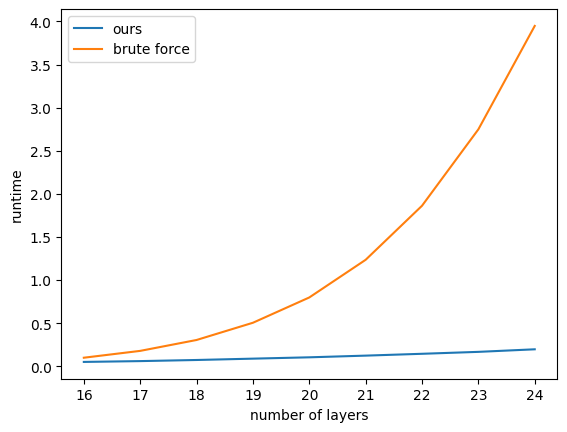

In [ ]:
plt.plot([16,17, 18, 19, 20, 21, 22, 23, 24], dp_time, label="ours")
plt.plot([16,17, 18, 19, 20, 21, 22, 23, 24], bf_time, label="brute force")
plt.xlabel("number of layers")
plt.ylabel("runtime")
plt.legend(loc="best")